In [1]:
import sys
sys.path.append('..')

import optimus
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d
import numpy as np
from optimus.source.transducers import transducer_field

# 3D


In [2]:
loaded_arr = np.loadtxt("MUSCLE_IPP_abs.txt")

IPP_abs = loaded_arr.reshape(
    loaded_arr.shape[0], loaded_arr.shape[1] // 201, 201)

In [3]:
frequency = 500e3 # 1MHz
a = 0.003 #3cm
D = 0.18 #18 cm
centroid_file='Data/default_random_array_centroid_locations.dat'
source = optimus.source.create_array(frequency, element_radius=a, centroid_locations_filename=centroid_file,
                                     location=[-D, 0, 0], number_of_point_sources_per_wavelength=2, velocity=0.4)

sphere_radius = 7.5e-3
geometry = optimus.geometry.shapes.Sphere(radius=7.5e-3, element_size=0.75e-3)
material_ext = optimus.material.load_material('muscle') #CAMBIE A MUSCULO POR ALPLA MUY BAJO EN WATER
material_int = optimus.material.load_material('bone (cortical)')

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import proj3d

x = source.centroid_locations[0, :]
y = source.centroid_locations[1, :]
z = source.centroid_locations[2, :]


import numpy as np
Nx = 201
Ny = 101
Nz = 101
# Zmax = 0.05 Nz=101 quizas menos
xmin, xmax, ymin, ymax, zmin, zmax = [-D, D, -0.05, 0.05, -0.05, 0.05]

In [4]:
c_0 = material_ext.speed_of_sound #bien
rho_0 = material_ext.density #bien
C_t = material_ext.heat_capacity #/ 1000 #DIVIDIRRRR
k_t = material_ext.thermal_conductivity
eta = material_ext.attenuation_pow_b #attenuation_pow_b
#P = incident_pressure_plot.copy()
alpha_0 = material_ext.attenuation_coeff_a # Np/m
#alpha_0 = material_ext.attenuation_coeff_a * 8.69 # dB/m

In [5]:
I = (IPP_abs)**2 / (c_0 * rho_0)
alpha = alpha_0 * frequency / 1000000
Q = I.copy()
Q = 2 * alpha * I

In [6]:
delta_x = (xmax - xmin) / Nx
delta_y = (ymax - ymin) / Ny
delta_z = (zmax - zmin) / Nz

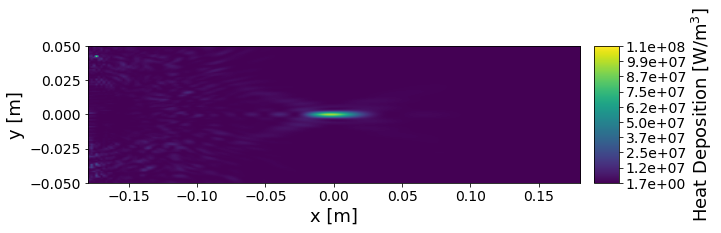

In [7]:
from optimus.postprocess.plot import surface_plot

theta = np.linspace(0, 2*np.pi, 100)
edge_sphere = (geometry.origin[0] + geometry.radius * np.cos(theta),
               geometry.origin[1] + geometry.radius * np.sin(theta))

T_test = Q[50]
fig = surface_plot(T_test,
                   axes_lims=(xmin, xmax, ymin, ymax),
                   axes_labels=("x [m]", "y [m]"),
                   colormap='viridis',
                   colormap_lims=[np.min(T_test),np.max(T_test)],
                   colorbar_unit="Heat Deposition [W/m$^3$]",
                   )

 ### Reducir tamaño matriz Q

In [8]:
Q = 2 * alpha * I
Q_copy = Q.copy()

bordes_x = 50 #queda de 2*bordes_x+1
bordes_y = 25

In [9]:
Q = [corte[51-bordes_y: 51+bordes_y+1, 101-bordes_x: 101+bordes_x+1] for corte in Q_copy]
Q = np.array(Q)
#Punto medio es [25][50]

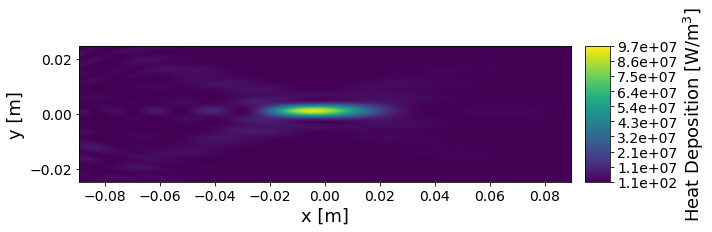

In [10]:
theta = np.linspace(0, 2*np.pi, 100)
edge_sphere = (geometry.origin[0] + geometry.radius * np.cos(theta),
               geometry.origin[1] + geometry.radius * np.sin(theta))

T_test = Q[50]
fig = surface_plot(T_test,
                   axes_lims=(delta_x * (-bordes_x), delta_x * (bordes_x), 
                              delta_y * (-bordes_y), delta_y * (bordes_y)),
                   axes_labels=("x [m]", "y [m]"),
                   colormap='viridis',
                   colormap_lims=[np.min(T_test),np.max(T_test)],
                   colorbar_unit="Heat Deposition [W/m$^3$]",
                   )

### Experimento calcular avance T en punto medio

In [11]:
Nx = 2 * bordes_x + 1
Ny = 2 * bordes_y + 1

In [12]:
(Nx, Ny, Nz)

(101, 51, 101)

In [13]:
def next_it_numpy(T, Q): #ANADIR FUNCION PARA AMORTIGUAR Q
    T_ret = np.zeros_like(T) + t_0
    A = 1 - 2 * delta_t * k_t / (rho_0 * C_t) * (delta_x ** (-2) + delta_y ** (-2) + delta_z ** (-2))
    B = delta_t * k_t / (rho_0 * C_t) * (delta_x ** (-2))
    C = delta_t * k_t / (rho_0 * C_t) * (delta_y ** (-2))
    D = delta_t * k_t / (rho_0 * C_t) * (delta_z ** (-2))
    E = delta_t / (rho_0 * C_t)
    T_ret[1:Nz-1, 1:Ny-1, 1:Nx-1] = (Q[1:Nz-1, 1:Ny-1, 1:Nx-1] * E +
                             T[1:Nz-1, 1:Ny-1, 1:Nx-1] * A +
                             (T[1:Nz-1, 1:Ny-1, 0:Nx-2] + T[1:Nz-1, 1:Ny-1, 2:Nx]) * B + 
                             (T[1:Nz-1, 0:Ny-2, 1:Nx-1] + T[1:Nz-1, 2:Ny, 1:Nx-1]) * C +
                             (T[0:Nz-2, 1:Ny-1, 1:Nx-1] + T[2:Nz, 1:Ny-1, 1:Nx-1]) * D
                        )
    return T_ret

In [14]:
delta_t = 1e-3 #milisegundos #100 puntos por pulso
Nt = 10000

t_0 = 37

T_0 = np.zeros_like(Q) + t_0

In [ ]:
%%time
Q_0 = np.zeros_like(Q)
temps = []
T_prev = T_0
for i in range(Nt):
    temps.append(T_prev[50][25][50])
    T_prev = next_it_numpy(T_prev, Q)

In [ ]:
fig = surface_plot(T_prev[50],
                   axes_lims=(delta_x * (-bordes_x), delta_x * (bordes_x), 
                              delta_y * (-bordes_y), delta_y * (bordes_y)),
                   axes_labels=("x [m]", "y [m]"),
                   colormap='viridis',
                   colormap_lims=[np.min(T_prev),np.max(T_prev)],
                   colorbar_unit="T",
                   )

In [ ]:
tiempos = np.arange(Nt) * delta_t #CAMBIAR 100 por Nt

plt.plot(tiempos, temps)

In [ ]:
%%time
Nt = 5
Q_0 = np.zeros_like(Q)
temps_2 = []
T_prev_2 = T_0
for i in range(Nt):
    temps.append(T_prev[50][25][50])
    T_prev_2 = next_it_numpy(T_prev_2, Q)

In [ ]:
fig = surface_plot(T_prev_2[50],
                   axes_lims=(delta_x * (-bordes_x), delta_x * (bordes_x), 
                              delta_y * (-bordes_y), delta_y * (bordes_y)),
                   axes_labels=("x [m]", "y [m]"),
                   colormap='viridis',
                   colormap_lims=[np.min(T_prev_2),np.max(T_prev_2)],
                   colorbar_unit="T",
                   )

In [ ]:
delta_t = 10e-3 #milisegundos #100 puntos por pulso

### Agregar Amortiguador y pulsos

Pulsos duran 2e-3 seg, por lo que delta_t = 2e-3/100 = 2e-5. Total pulsos son 3e-1, por lo que Nt = 1.5e4. Se repiten cada 4e-3 seg. 100 iteraciones si, 100 no.

In [208]:
delta_t = 2e-5
Nt = int(1.5e4)

In [164]:
def get_am(iteracion):
    if iteracion % 200 < 100:
        return 1
    else:
        return 0

In [18]:
def next_it_numpy_am(T, Q, am): #am es amortiguador en ese tiempo
    T_ret = np.zeros_like(T) + t_0
    A = 1 - 2 * delta_t * k_t / (rho_0 * C_t) * (delta_x ** (-2) + delta_y ** (-2) + delta_z ** (-2))
    B = delta_t * k_t / (rho_0 * C_t) * (delta_x ** (-2))
    C = delta_t * k_t / (rho_0 * C_t) * (delta_y ** (-2))
    D = delta_t * k_t / (rho_0 * C_t) * (delta_z ** (-2))
    E = delta_t / (rho_0 * C_t)
    T_ret[1:Nz-1, 1:Ny-1, 1:Nx-1] = (Q[1:Nz-1, 1:Ny-1, 1:Nx-1] * E * am +
                             T[1:Nz-1, 1:Ny-1, 1:Nx-1] * A +
                             (T[1:Nz-1, 1:Ny-1, 0:Nx-2] + T[1:Nz-1, 1:Ny-1, 2:Nx]) * B + 
                             (T[1:Nz-1, 0:Ny-2, 1:Nx-1] + T[1:Nz-1, 2:Ny, 1:Nx-1]) * C +
                             (T[0:Nz-2, 1:Ny-1, 1:Nx-1] + T[2:Nz, 1:Ny-1, 1:Nx-1]) * D
                        )
    return T_ret

In [209]:
%%time
temps = []
T_prev = T_0
for i in range(Nt):
    am = get_am(i)
    temps.append(np.max(T_prev))
    T_prev = next_it_numpy_am(T_prev, Q, am)
    
temps.append(np.max(T_prev))

CPU times: user 9min 3s, sys: 19.8 ms, total: 9min 3s
Wall time: 9min 3s


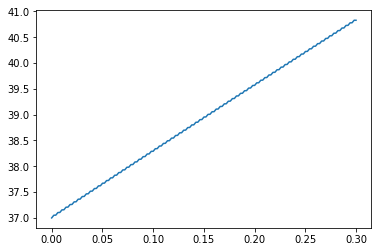

In [177]:
tiempos = np.arange(Nt + 1) * delta_t 
plt.plot(tiempos, temps)

In [207]:
np.max(T_prev)

42.07841617202596

In [153]:
T_prev[50][25][50]

39.95215998481853

In [162]:
T_prev[50][24][49]

40.73548173744271

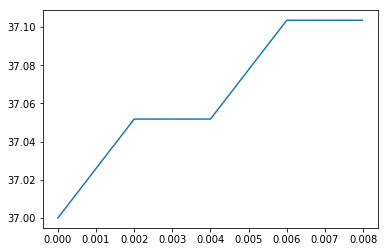

In [178]:
plt.plot(tiempos[:400], temps[:400])

In [ ]:
T_test = T_prev[50]
fig = surface_plot(T_test,
                   axes_lims=(delta_x * (-bordes_x), delta_x * (bordes_x), 
                              delta_y * (-bordes_y), delta_y * (bordes_y)),
                   axes_labels=("x [m]", "y [m]"),
                   colormap='viridis',
                   colormap_lims=[37,np.max(T_test)],
                   colorbar_unit="T",
                   )

In [213]:
temps[100]

37.05180624387958

In [214]:
temps[200]

37.05179574737417

### Experimento dejar punto alto

In [13]:
Q_punt = np.zeros_like(Q)

Q_punt[51][26][51] = 1e8 #8

In [12]:
np.max(Q)

96640680.54333755

In [14]:
Q[51][26][51]

29905760.6742095

In [19]:
%%time

delta_t = 2e-3
Nt = int(4e2)

temps = []
T_prev = T_0
T_arr = []
for i in range(Nt):
    #am = get_am(i)
    am = 1
    temps.append(np.max(T_prev))
    T_arr.append(T_prev)
    T_prev = next_it_numpy_am(T_prev, Q_punt, am)
    
temps.append(np.max(T_prev))
T_arr.append(T_prev)

ValueError: operands could not be broadcast together with shapes (99,50,101) (99,50,99) 

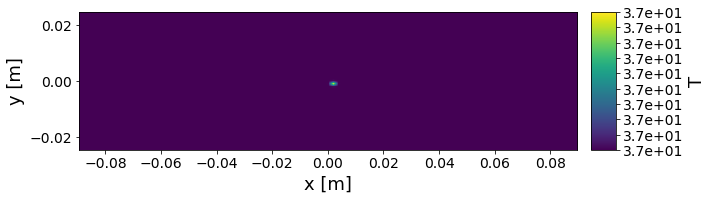

In [204]:
T_test = T_arr[-1][50]
fig = surface_plot(T_test,
                   axes_lims=(delta_x * (-bordes_x), delta_x * (bordes_x), 
                              delta_y * (-bordes_y), delta_y * (bordes_y)),
                   axes_labels=("x [m]", "y [m]"),
                   colormap='viridis',
                   colormap_lims=[37,np.max(T_test)],
                   colorbar_unit="T",
                   )

In [205]:
np.max(T_prev)

44.34594909020594

- Acotar valores de z
- Iterar hasta convergencia (ir eliminando historial, por ejemplo guardar cada 100 iteraciones). Amortiguar Q es una posibilidad.
- Implementar matrices e invertir. Usar sparse. Pero primero intentar el punto anterior
- Revisar si no apagar Q hace que se caliente el doble de rápido.
- Intentar entender porque usan esos pulsos en paper.
- Comparar orden de magnitud de $k\nabla^2T$ y de $Q$. $\partial u/\partial t$ comparar con más variableds. 
- Revisar ordene de magnitud.